# Прогнозирование температуры стали для завода ООО "Так закаляем сталь"

**Краткая суть**

Необходимо построить модель, которая будет прогнозировать температуру стали 

**Описание**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.


***Наша работа поможет сократить расходы не электроэнергию и поможет оптимизировать процесс.***

**Критерии оценки модели**

* Значение метрики MAE на тестовой выборке должно быть ниже 6.8

**План выполнения проекта**

1. Загрузить данные
2. Проанализировать данные / Провести исследовательский анализ данных
3. Выполнить предобработку
4. Обучить разные модели с различными гиперпараметрами (тестовая выборка должна быть размером 25% от исходных данных)
5. Проверить данные на тестовой выборке, убедиться что итоговая метрика ниже 6.8
6. Сделать выводы
7. Отчет

## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()

from shap import TreeExplainer, Explanation
from shap.plots import waterfall

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

import math

from scipy.stats import lognorm, randint, uniform

import statsmodels.api as sm

import warnings

import time

from tqdm import tqdm

plt.style.use('dark_background')
warnings.filterwarnings('ignore')

## Создадим переменную, в которой будем сохранять путь к файлам. Загрузим данные

In [2]:
PATH = './datasets/final_steel/' # путь файлов      

In [3]:
data_arc  = 'data_arc.csv'
data_bulk = 'data_bulk.csv'
data_bulk_time = 'data_bulk_time.csv'
data_gas  = 'data_gas.csv'
data_temp = 'data_temp.csv'
data_wire = 'data_wire.csv'
data_wire_time = 'data_wire_time.csv'

In [4]:
try:
    df_arc = pd.read_csv(f'{PATH}{data_arc}')  # данные об электродах
    print(f'Загрузили: {data_arc}')
    df_bulk = pd.read_csv(
        f'{PATH}{data_bulk}')  # данные о подаче сыпучих материалов (объём)
    print(f'Загрузили: {data_bulk}')
    df_bulk_time = pd.read_csv(f'{PATH}{data_bulk_time}'
                               )  # данные о подаче сыпучих материалов (время)
    print(f'Загрузили: {data_bulk_time}')
    df_gas = pd.read_csv(f'{PATH}{data_gas}')  # данные о продувке сплава газом
    print(f'Загрузили: {data_gas}')
    df_temp = pd.read_csv(
        f'{PATH}{data_temp}')  # результаты измерения температуры
    print(f'Загрузили: {data_temp}')
    df_wire = pd.read_csv(
        f'{PATH}{data_wire}')  # данные о проволочных материалах (объём)
    print(f'Загрузили: {data_wire}')
    df_wire_time = pd.read_csv(
        f'{PATH}{data_wire_time}')  # данные о проволочных материалах (время)
    print(f'Загрузили: {data_wire_time}')

except:

    print('Something is wrong')

Загрузили: data_arc.csv
Загрузили: data_bulk.csv
Загрузили: data_bulk_time.csv
Загрузили: data_gas.csv
Загрузили: data_temp.csv
Загрузили: data_wire.csv
Загрузили: data_wire_time.csv


## Напишем функцию для выводы информации по данным

In [5]:
def check_data(df):
    '''Функция получения первичной информации о датафрейме'''
    print('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print('------------- Последние 5 строк ------------')
    display(df.tail())
    print('')
    print('')
    print('------------- Типы данных ------------')
    print(df.info())
    print('')
    print('')
    print('------------- Описательная статистика столбцов ------------')
    print(df.describe(include='all'))
    print('')
    print('')
    print('------------- Пропуски ------------')
    display(
        pd.DataFrame({
            "Кол-во пропусков": df.isna().sum(),
            "% пропусков": round((df.isna().mean() * 100), 2)
        }).style.format('{:.2f}').background_gradient('coolwarm'))
    print("Всего колонок: {}, без пропусков: {}, с пропусками: {}".format(
        len(df.isna().sum()), (df.isna().sum() == 0).sum(), (df.isna().sum() != 0).sum()))
    print('')
    print('')
    print('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

## Посмотрим на каждый датасет и выполним предобработку

### Данные об электродах

In [6]:
check_data(df_arc)

------------- Первые 5 строк ------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397




------------- Последние 5 строк ------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


------------- Описательная статистика столбцов ------------
                 key Начало нагрева дугой  Конец нагрева дугой  \
count   14876.000000                14876                14876   
unique           NaN                14875                14876   
top              NaN  2019-06-10 22:02:03  2019-05-03 11:06:02   
freq             NaN                    2                    1   
mean     1615.220422             

,Кол-во пропусков,% пропусков
key,0.00,0.00
Начало нагрева дугой,0.00,0.00
Конец нагрева дугой,0.00,0.00
Активная мощность,0.00,0.00
Реактивная мощность,0.00,0.00


Всего колонок: 5, без пропусков: 5, с пропусками: 0


------------- Дубликаты ------------
Дубликатов НЕТ


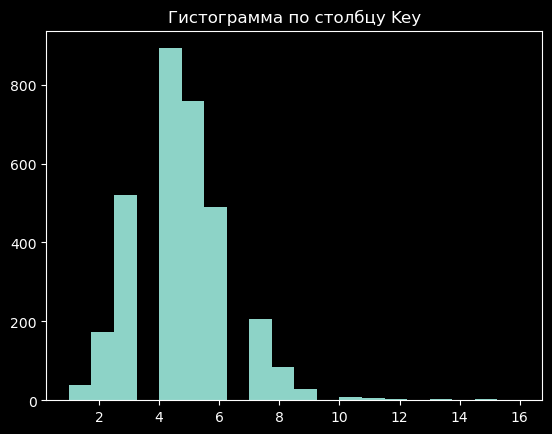

In [7]:
plt.hist((list(df_arc['key'].value_counts())), bins=20)
plt.title('Гистограмма по столбцу Key')
plt.show()

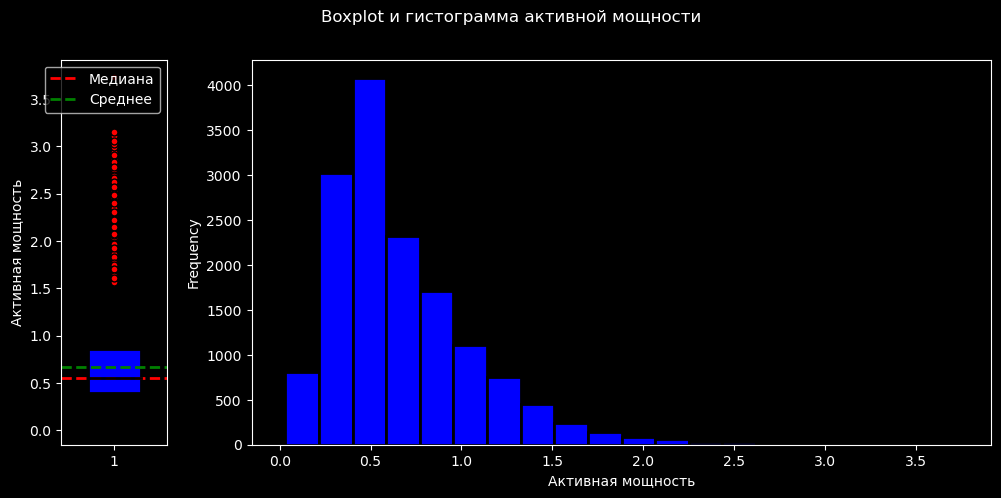

In [8]:
fig, axs = plt.subplots(1,
                        2,
                        figsize=(12, 5),
                        gridspec_kw={"width_ratios": [1, 7]})

# создаем boxplot
bp = axs[0].boxplot(
    df_arc['Активная мощность'],
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='blue', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1),
    medianprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=1),
    flierprops=dict(marker='o',
                    markersize=5,
                    markerfacecolor='red',
                    markeredgecolor='black'),
)

# ширина линий
for box in bp['boxes']:
    box.set_linewidth(2)

for whisker in bp['whiskers']:
    whisker.set_linewidth(1)

for median in bp['medians']:
    median.set_linewidth(2)

for cap in bp['caps']:
    cap.set_linewidth(1)
    
axs[0].axhline(df_arc['Активная мощность'].median(), color='r', linestyle='--', linewidth=2, label='Медиана')
axs[0].axhline(df_arc['Активная мощность'].mean(), color='g', linestyle='--', linewidth=2, label='Среднее')
axs[0].legend()

#создаем гистрограмму
df_arc['Активная мощность'].plot.hist(bins=20,
                                      ax=axs[1],
                                      edgecolor='black',
                                      linewidth=2,
                                      color='blue')

# названия
axs[0].set_ylabel('Активная мощность')
axs[1].set_xlabel('Активная мощность')

fig.suptitle('Boxplot и гистограмма активной мощности')

plt.show()

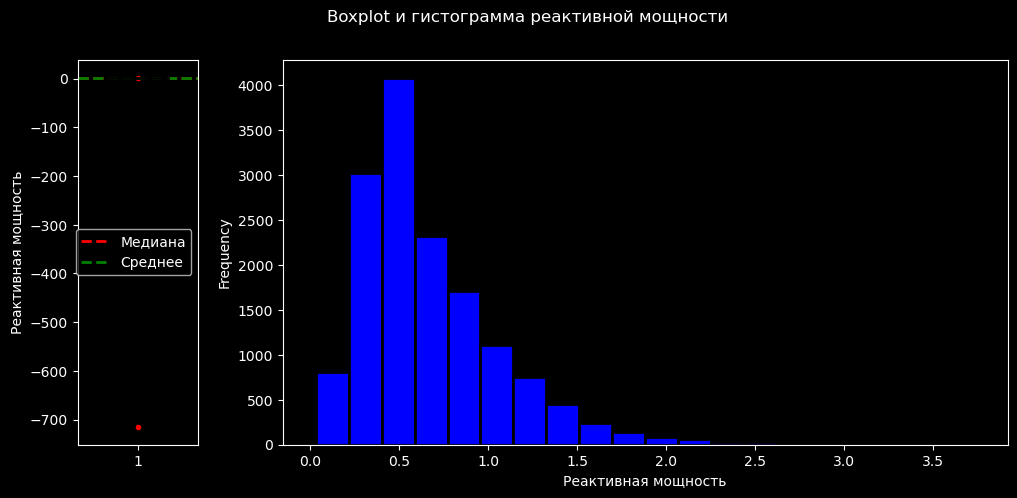

In [9]:
fig, axs = plt.subplots(1,
                        2,
                        figsize=(12, 5),
                        gridspec_kw={"width_ratios": [1, 6]})

# создаем boxplot
bp = axs[0].boxplot(
    df_arc['Реактивная мощность'],
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='blue', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1),
    medianprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=1),
    flierprops=dict(marker='o',
                    markersize=5,
                    markerfacecolor='red',
                    markeredgecolor='black'),
)

# ширина линий
for box in bp['boxes']:
    box.set_linewidth(2)

for whisker in bp['whiskers']:
    whisker.set_linewidth(1)

for median in bp['medians']:
    median.set_linewidth(2)

for cap in bp['caps']:
    cap.set_linewidth(1)
    
axs[0].axhline(df_arc['Реактивная мощность'].median(), color='r', linestyle='--', linewidth=2, label='Медиана')
axs[0].axhline(df_arc['Реактивная мощность'].mean(), color='g', linestyle='--', linewidth=2, label='Среднее')
axs[0].legend()

#создаем гистрограмму
df_arc['Активная мощность'].plot.hist(bins=20,
                                      ax=axs[1],
                                      edgecolor='black',
                                      linewidth=2,
                                      color='blue')

# названия
axs[0].set_ylabel('Реактивная мощность')
axs[1].set_xlabel('Реактивная мощность')


fig.suptitle('Boxplot и гистограмма реактивной мощности')

plt.show()

* в данной таблице нет пропусков
* в столбце "активаная мощность" распределение смещено вправо, это значит что мода < медиана < среднее
* в столбце "реактивная мощность" есть сильно отрицательное значение, нужно будет от него избавиться
* количество попыток нагрева варрируется от 1 до 16
* дубликатов нет

### Данные о подаче сыпучих материалов (объём)

In [10]:
check_data(df_bulk)

------------- Первые 5 строк ------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0




------------- Последние 5 строк ------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


------------- Описательная статистика столбцов ------------
               key      Bulk 1      Bulk 2      

,Кол-во пропусков,% пропусков
key,0.00,0.00
Bulk 1,2877.00,91.95
Bulk 2,3107.00,99.30
Bulk 3,1831.00,58.52
Bulk 4,2115.00,67.59
Bulk 5,3052.00,97.54
Bulk 6,2553.00,81.59
Bulk 7,3104.00,99.20
Bulk 8,3128.00,99.97
Bulk 9,3110.00,99.39


Всего колонок: 16, без пропусков: 1, с пропусками: 15


------------- Дубликаты ------------
Дубликатов НЕТ


* в данной таблице много пропусков (нужно понять причину и понять что делать, удалять или заполнять?)
* распределение сложно отслеживается. Видно что там, где пропусков не очень много, оно либо нормальное, либо смещено в правую сторону
* дубликатов нет

In [11]:
df_t = df_bulk.iloc[:, 1:].copy().fillna(0)

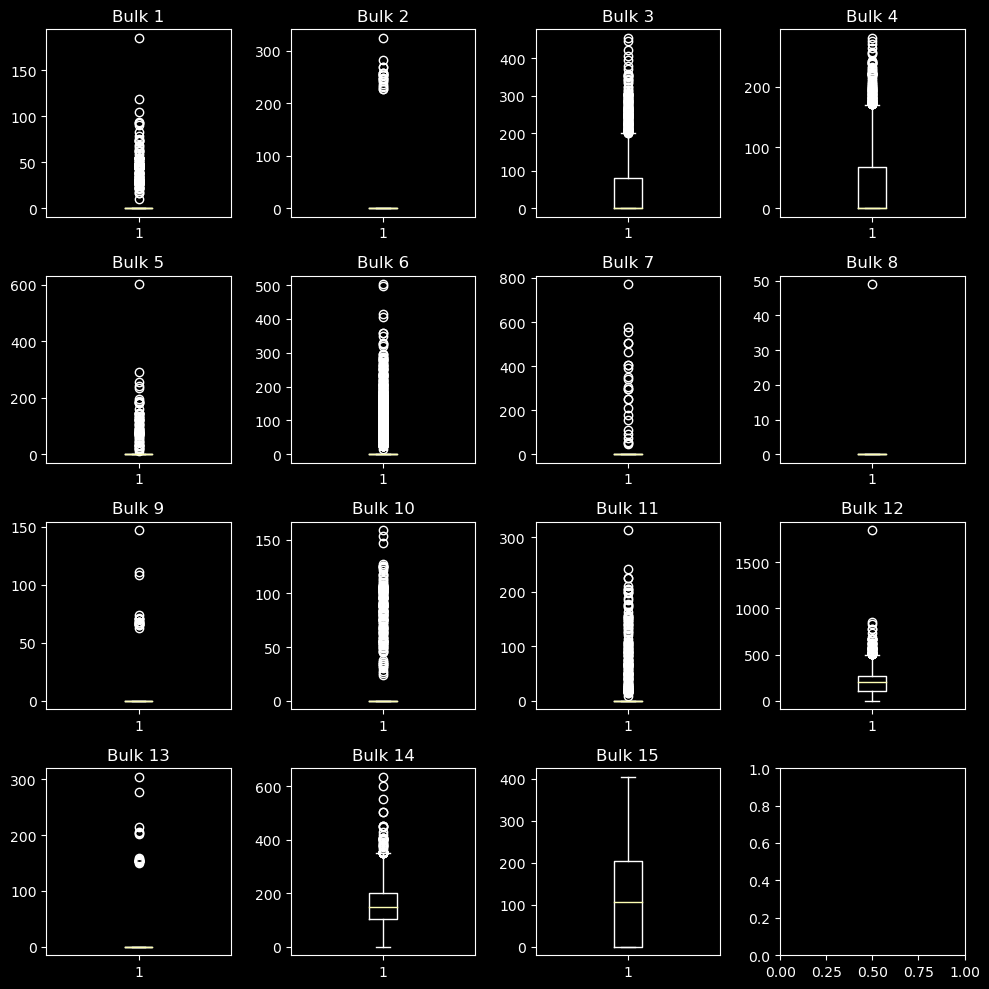

In [12]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in range(len(df_t.columns)):
    row = i // 4
    col = i % 4
    axs[row, col].boxplot(df_t.iloc[:, i])
    axs[row, col].set_title(df_t.columns[i])

plt.tight_layout()

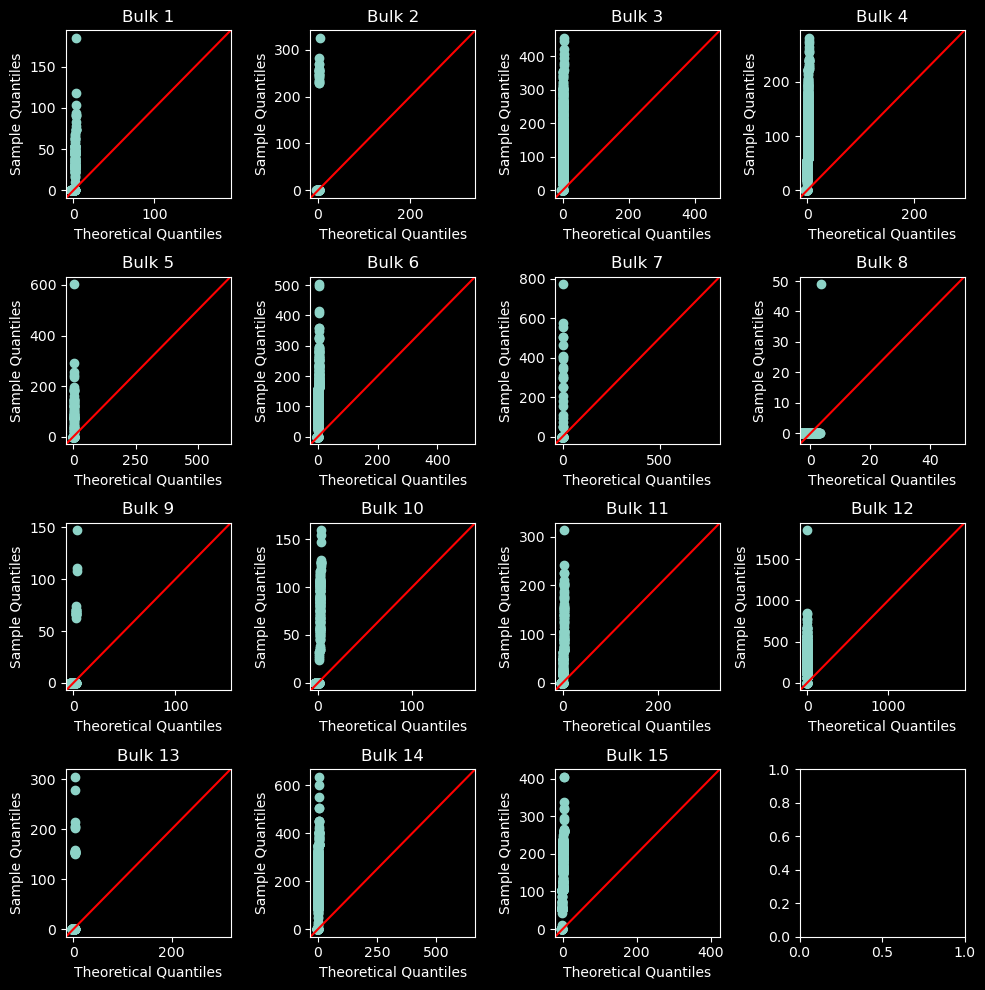

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in range(len(df_t.columns)):
    row = i // 4
    col = i % 4
    sm.qqplot(df_t.iloc[:, i], line='45', ax=axs[row, col])
    axs[row, col].set_title(df_t.columns[i])

plt.tight_layout()

* можно заметить, что везде не нормальное распределение. 
* из-за пропусков и выбросов сложно понять что у нас с данными
* некоторые материалы не участвуют в процессе, интересно почему? либо это в наших примерах так, либо это вообще так

### Данные о подаче сыпучих материалов (время)

In [14]:
check_data(df_bulk_time)

------------- Первые 5 строк ------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56




------------- Последние 5 строк ------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


------------- Описательная статистика столбцов ------------
                key               Bulk 1               Bulk 2  \
c

,Кол-во пропусков,% пропусков
key,0.00,0.00
Bulk 1,2877.00,91.95
Bulk 2,3107.00,99.30
Bulk 3,1831.00,58.52
Bulk 4,2115.00,67.59
Bulk 5,3052.00,97.54
Bulk 6,2553.00,81.59
Bulk 7,3104.00,99.20
Bulk 8,3128.00,99.97
Bulk 9,3110.00,99.39


Всего колонок: 16, без пропусков: 1, с пропусками: 15


------------- Дубликаты ------------
Дубликатов НЕТ


* много пропусков
* вся таблица только данные с датой
* дублей нет

### Данные о продувке сплава газом

In [15]:
df_gas.columns = ['key', 'gaz']  # переименуем столбцы

In [16]:
check_data(df_gas)

------------- Первые 5 строк ------------


,key,gaz
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692




------------- Последние 5 строк ------------


,key,gaz
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gaz     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


------------- Описательная статистика столбцов ------------
               key          gaz
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


------------- Пропуски ------------


,Кол-во пропусков,% пропусков
key,0.00,0.00
gaz,0.00,0.00


Всего колонок: 2, без пропусков: 2, с пропусками: 0


------------- Дубликаты ------------
Дубликатов НЕТ


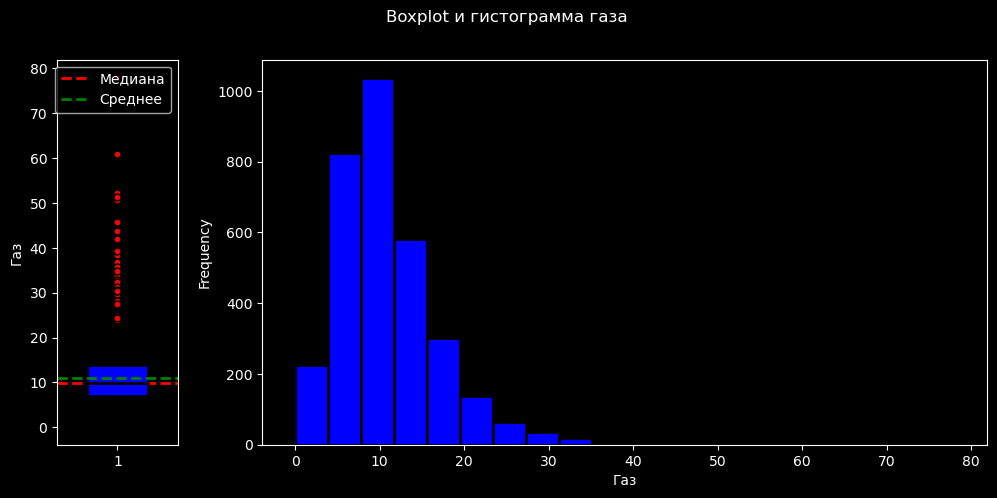

In [17]:
fig, axs = plt.subplots(1,
                        2,
                        figsize=(12, 5),
                        gridspec_kw={"width_ratios": [1, 6]})

# создаем boxplot
bp = axs[0].boxplot(
    df_gas['gaz'],
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='blue', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1),
    medianprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=1),
    flierprops=dict(marker='o',
                    markersize=5,
                    markerfacecolor='red',
                    markeredgecolor='black'),
)

# ширина линий
for box in bp['boxes']:
    box.set_linewidth(2)

for whisker in bp['whiskers']:
    whisker.set_linewidth(1)

for median in bp['medians']:
    median.set_linewidth(2)

for cap in bp['caps']:
    cap.set_linewidth(1)
    
axs[0].axhline(df_gas['gaz'].median(), color='r', linestyle='--', linewidth=2, label='Медиана')
axs[0].axhline(df_gas['gaz'].mean(), color='g', linestyle='--', linewidth=2, label='Среднее')
axs[0].legend()

#создаем гистрограмму
df_gas['gaz'].plot.hist(bins=20,
                                      ax=axs[1],
                                      edgecolor='black',
                                      linewidth=2,
                                      color='blue')

# названия
axs[0].set_ylabel('Газ')
axs[1].set_xlabel('Газ')


fig.suptitle('Boxplot и гистограмма газа')

plt.show()

* пропусков нет
* распределение не нормальное, есть выбросы
* распределение смещено в правую сторону
* максимальное значение 77.99, минимальное 0, медиана 9.83, среднее 11 
* дублей нет

### Результаты измерения *температуры* (целевая переменная)

In [18]:
check_data(df_temp)

------------- Первые 5 строк ------------


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0




------------- Последние 5 строк ------------


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


------------- Описательная статистика столбцов ------------
                 key         Время замера   Температура
count   15907.000000                15907  13006.000000
unique           NaN                15907           NaN
top              NaN  2019-05-03 11:16:18           NaN
freq             NaN                    1           NaN
mean     1607.880870                  NaN   1591.840920
std       942.212073                  NaN     21.375851
min         1.000000                  NaN   1191.000000
25%       790.000000                  NaN   1581.000000
5

,Кол-во пропусков,% пропусков
key,0.00,0.00
Время замера,0.00,0.00
Температура,2901.00,18.24


Всего колонок: 3, без пропусков: 2, с пропусками: 1


------------- Дубликаты ------------
Дубликатов НЕТ


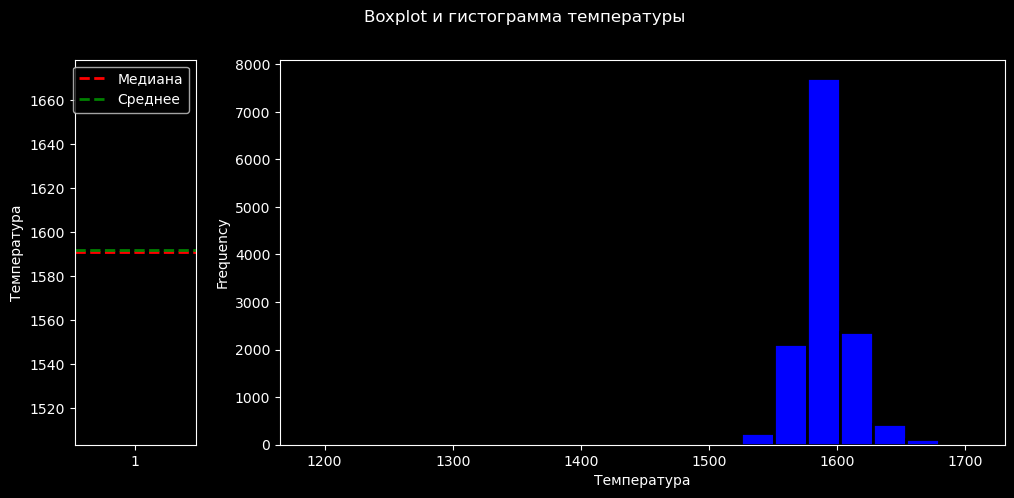

In [19]:
fig, axs = plt.subplots(1,
                        2,
                        figsize=(12, 5),
                        gridspec_kw={"width_ratios": [1, 6]})

# создаем boxplot
bp = axs[0].boxplot(
    df_temp['Температура'],
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='blue', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1),
    medianprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=1),
    flierprops=dict(marker='o',
                    markersize=5,
                    markerfacecolor='red',
                    markeredgecolor='black'),
)

# ширина линий
for box in bp['boxes']:
    box.set_linewidth(2)

for whisker in bp['whiskers']:
    whisker.set_linewidth(1)

for median in bp['medians']:
    median.set_linewidth(2)

for cap in bp['caps']:
    cap.set_linewidth(1)
    
axs[0].axhline(df_temp['Температура'].median(), color='r', linestyle='--', linewidth=2, label='Медиана')
axs[0].axhline(df_temp['Температура'].mean(), color='g', linestyle='--', linewidth=2, label='Среднее')
axs[0].legend()

#создаем гистрограмму
df_temp['Температура'].plot.hist(bins=20,
                                      ax=axs[1],
                                      edgecolor='black',
                                      linewidth=2,
                                      color='blue')

# названия
axs[0].set_ylabel('Температура')
axs[1].set_xlabel('Температура')


fig.suptitle('Boxplot и гистограмма температуры')

plt.show()

* пропуски есть, почти 19%
* распределение не нормальное и смещено влево
* максимальная температура 1705°, минимальная 1191°, медиана и среднее равны - 1591°
* дублей нет

### Данные о проволочных материалах (объём)

In [20]:
check_data(df_wire)

------------- Первые 5 строк ------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN




------------- Последние 5 строк ------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


------------- Описательная статистика столбцов ------------
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99

,Кол-во пропусков,% пропусков
key,0.00,0.00
Wire 1,26.00,0.84
Wire 2,2002.00,64.98
Wire 3,3018.00,97.96
Wire 4,3067.00,99.55
Wire 5,3080.00,99.97
Wire 6,3008.00,97.63
Wire 7,3070.00,99.64
Wire 8,3062.00,99.38
Wire 9,3052.00,99.06


Всего колонок: 10, без пропусков: 1, с пропусками: 9


------------- Дубликаты ------------
Дубликатов НЕТ


In [21]:
df_t = df_wire.iloc[:, 1:].copy().fillna(0)

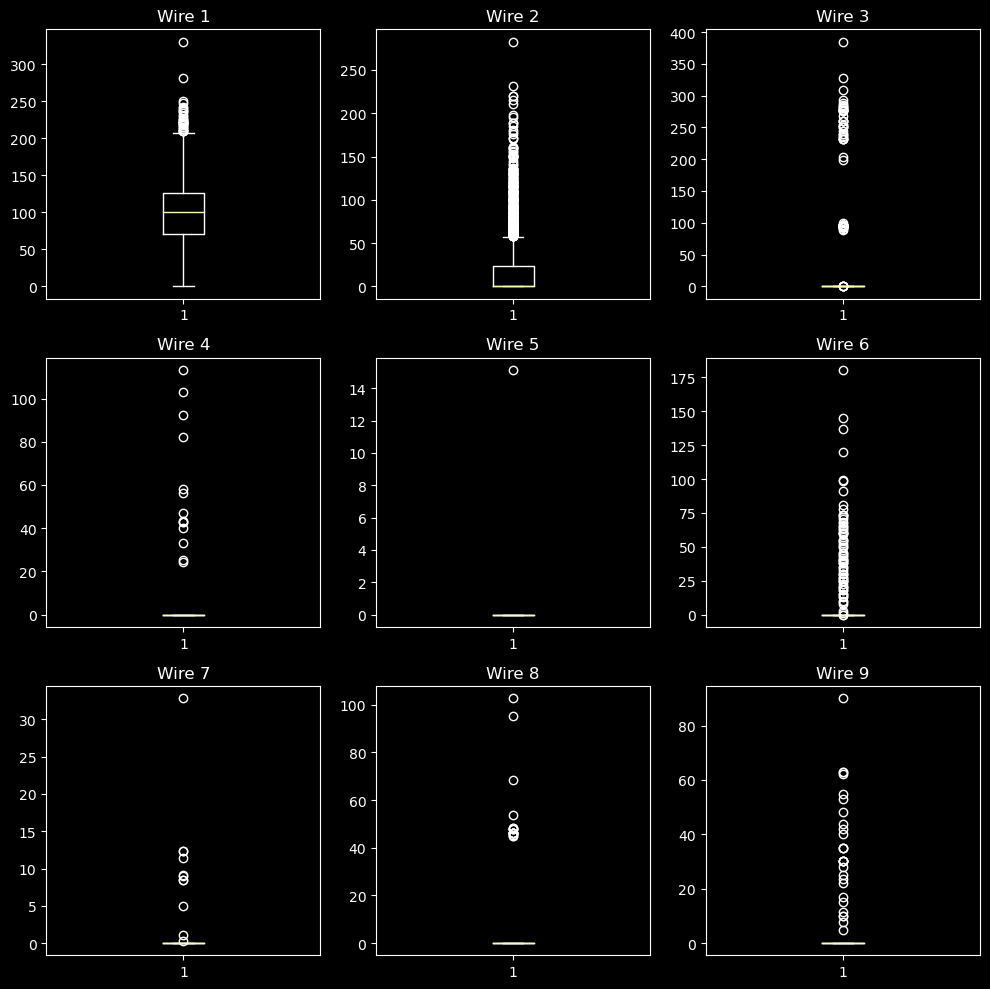

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(len(df_t.columns)):
    row = i // 3
    col = i % 3
    axs[row, col].boxplot(df_t.iloc[:, i])
    axs[row, col].set_title(df_t.columns[i])

plt.tight_layout()

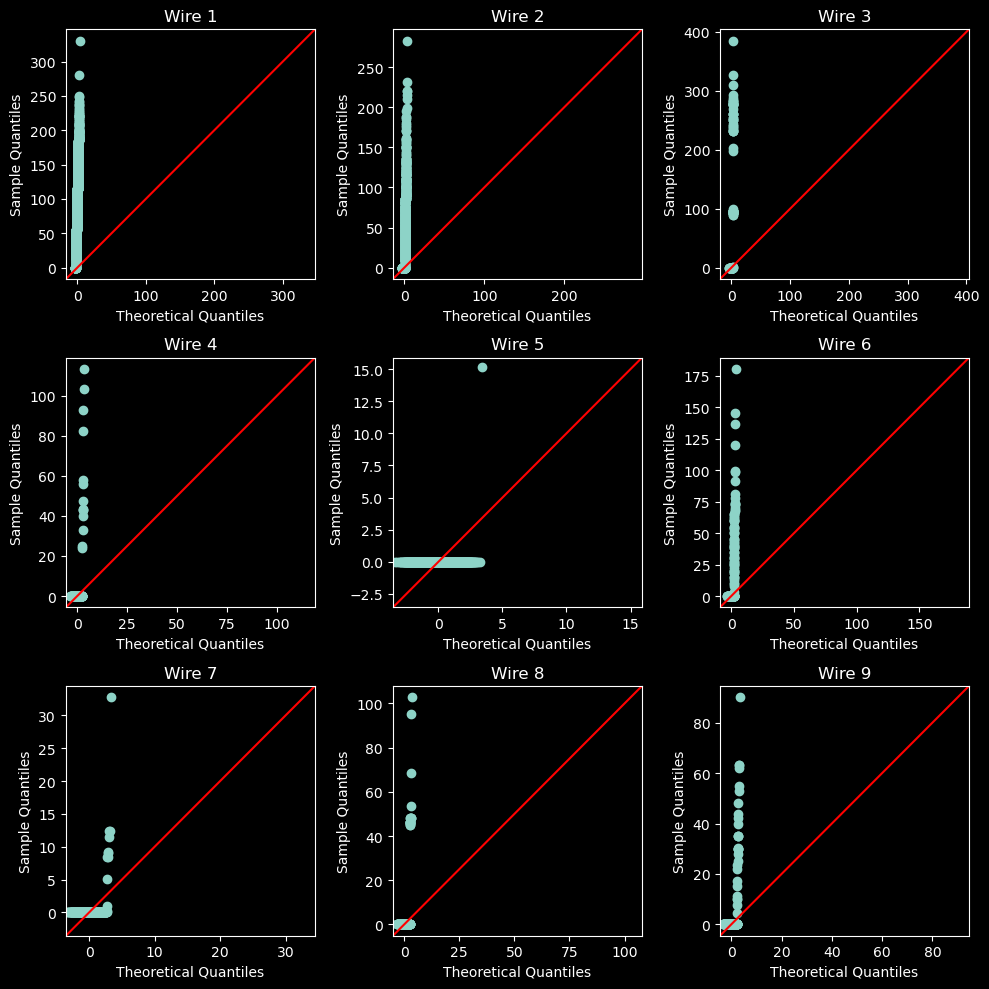

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(len(df_t.columns)):
    row = i // 3
    col = i % 3
    sm.qqplot(df_t.iloc[:, i], line='45', ax=axs[row, col])
    axs[row, col].set_title(df_t.columns[i])

plt.tight_layout()

Картина сильно напоминает картину в сыпучих материалах

* в таблице много пропусков (нужно понять причину и понять что делать, удалять или заполнять?)
* распределение везде не нормальное
* дубликатов нет
* из-за пропусков и выбросов сложно понять что у нас с данными
* картина как и сыпучих материалов, некоторые не участвуют в процессе

### Данные о проволочных материалах (время)

In [24]:
check_data(df_wire_time)

------------- Первые 5 строк ------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN




------------- Последние 5 строк ------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


------------- Описательная статистика столбцов ------------
                key               Wire 1               Wire 2  \
count   3081.000000                 3055                 1079   
unique          NaN                 3055                 1079   
top             NaN  2019-05-03 11:11:41  2019-05-03 13:32:06   
freq            NaN                    1 

,Кол-во пропусков,% пропусков
key,0.00,0.00
Wire 1,26.00,0.84
Wire 2,2002.00,64.98
Wire 3,3018.00,97.96
Wire 4,3067.00,99.55
Wire 5,3080.00,99.97
Wire 6,3008.00,97.63
Wire 7,3070.00,99.64
Wire 8,3062.00,99.38
Wire 9,3052.00,99.06


Всего колонок: 10, без пропусков: 1, с пропусками: 9


------------- Дубликаты ------------
Дубликатов НЕТ


* много пропусков
* вся таблица только данные с датой
* дублей нет

# Предобработка

## Данные об электродах

In [25]:
df_arc.columns = [
    'key', 'starting_heating', 'ending_heating', 'active_power',
    'reactive_power'
]  # переименуем столбцы

In [26]:
df_arc.iloc[:, 3:].describe() 

,active_power,reactive_power
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


Можно заметить что в столбце реактивной мощности есть отрицательное значение, конкретно здесь это выброс, поэтому избавимся от него.

In [27]:
df_arc.query('reactive_power < 0')  # посмотрим сколько отрицательных значений

,key,starting_heating,ending_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [28]:
df_arc.query('key == 2116')

,key,starting_heating,ending_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


**Восстановим реактивную мощность**

In [29]:
df_arc['dif_power'] = df_arc['reactive_power'] / df_arc[
    'active_power']  # находим разницу между реактивной и активной мощностями

In [30]:
df_arc.loc[df_arc['reactive_power'] < 0, 'reactive_power'] = abs(
    df_arc['reactive_power']).mean() * abs(df_arc['dif_power']).mean(
    )  # заменяем отрицательное значение на среднее произведение dif_power и active_power

In [31]:
df_arc['starting_heating'] = pd.to_datetime(
    df_arc['starting_heating'],
    format='%Y.%m.%d %H:%M:%S')  # приводим к формату даты
df_arc['ending_heating'] = pd.to_datetime(
    df_arc['ending_heating'],
    format='%Y.%m.%d %H:%M:%S')  # приводим к формату даты

In [32]:
df_arc['elec_time'] = df_arc['ending_heating'] - df_arc[
    'starting_heating']  # находим продолжительность подачи электричества на каждой итерации

df_arc['elec_time'] = df_arc['elec_time'].dt.total_seconds(
)  # переводим в секунды

df_sum_elec_time = df_arc.groupby('key')['elec_time'].agg(
    ['count', 'sum']
)  # находим суммарную продолжительность нагрева и количество нагрева по каждой партии

df_sum_elec_time = pd.DataFrame(df_sum_elec_time)  # собираем датафрейм
df_sum_elec_time.columns = ['count_iter_time',
                            'sum_elec_time']  # переименовываем столбец

In [33]:
df_apower_mean = pd.DataFrame(
    df_arc.groupby('key')
    ['active_power'].mean())  # получаем среднюю активую мощность по партии

In [34]:
df_repower_mean = pd.DataFrame(
    df_arc.groupby('key')
    ['reactive_power'].mean())  # получаем среднюю реактивую  мощность по партии

In [35]:
df_powers = pd.merge(df_apower_mean, df_repower_mean, how='inner',
                     on='key')  # объединим мощности
df_powers = df_powers.merge(df_sum_elec_time, how='inner',
                            on='key')  # добавляем сумарное время нагрева

**Посчитаем среднюю полную мощность по формуле $$S = √P^2 + Q^2$$**

In [36]:
df_powers['full_power'] = (
    (df_powers['active_power'])**2 +
    (df_powers['reactive_power'])**2)**0.5  # средняя полная мощность

In [37]:
df_powers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   active_power     3214 non-null   float64
 1   reactive_power   3214 non-null   float64
 2   count_iter_time  3214 non-null   int64  
 3   sum_elec_time    3214 non-null   float64
 4   full_power       3214 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


Нами была выполнена предобработка данных об электродах, а именно:
* переименовали колонки для удобства
* столбцы с датой привели к формату даты
* нашли продолжительность подачи электричества по каждой партии в секундах
* нашли средние мощности по партиям
* нашли количество нагревов по каждой партии
* посчитали полные мощности для каждой партии
* объединили все в один датасет

## Посмотрим детально на данные об объеме подачи сыпучих материалов

In [38]:
df_bulk.isna().sum() * 100 / len(df_bulk)  # считаем пропуски

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

**Пропусков очень много, поэтому стоило бы удалить те столбцы, где больше 90% данных нет. НО, это в нашей выборке сейчас этих данных нет, а в другой раз они могут и быть. Если мы удалим их из модели, то она не сможет их обрабатывать. Окончательно поймем все после первого обучения и анализа модели**

In [39]:
df_bulk = df_bulk.fillna(0)  # заполняем все нулями

In [40]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


## Посмотрим на таблицу с целевым признаком

In [41]:
df_temp.columns = ['key', 'time', 'temperature']  # переименуем столбцы

In [42]:
df_temp['time'] = pd.to_datetime(
    df_temp['time'],
    format='%Y.%m.%d %H:%M:%S')  # приводим данные к формату даты

In [43]:
df_temp = df_temp[~df_temp['key'].isin(df_temp['key'].value_counts()[
    df_temp['key'].value_counts() == 1].index)] # удаляем партии, по которым только 1 замер

### Начальную температуру мы знаем всегда, поэтому получим её и получим нашу целевую переменную

In [44]:
df_min_t = pd.merge(df_temp.groupby('key')['time'].min(),
                    df_temp,
                    how='inner',
                    on='time')  # получаем начальную температуру

In [45]:
df_max_t = pd.merge(df_temp.groupby('key')['time'].max(),
                    df_temp,
                    how='inner',
                    on='time')  # получаем целевую переменную

In [46]:
df_full = pd.merge(df_min_t, df_max_t, on='key',
                   how='inner')  # объединяем данные с температурами

In [47]:
df_full.columns = [
    'start_time', 'key', 'starting_temp', 'ending_time', 'final_temp'
    
]  # изменяем названия колонок для удобства

In [48]:
df_full['duration'] = df_full['ending_time'] - df_full[
    'start_time']  # добавим время между первым и последним измерениями

df_full['duration'] = df_full['duration'].dt.total_seconds(
)  # переведем в секунды

In [49]:
df_full = df_full[df_full['starting_temp'] >= 1500]
  # удаляем пропуски и ограничиваемся начальной температурой в 1500°

In [50]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3209 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   start_time     3209 non-null   datetime64[ns]
 1   key            3209 non-null   int64         
 2   starting_temp  3209 non-null   float64       
 3   ending_time    3209 non-null   datetime64[ns]
 4   final_temp     2471 non-null   float64       
 5   duration       3209 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 175.5 KB


Нами была выполнена предобработка данных об электродах, а именно:
* переименовали колонки для удобства
* столбцы с датой привели к формату даты
* определили начальную и финальные температуры
* удалили партии, по которым был проивзеден только один замер
* удалили партии, у которые начальные измерения были ниже 1500°
* объединили все в один датасет

## Посмотрим на данные об объёме проволочных материалов

In [51]:
df_wire.isna().sum() * 100 / len(df_wire)  # считаем пропуски

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

**Картина схожая с сыпучими материалами, план такой же.**

In [52]:
df_wire = df_wire.fillna(0)  # заполняем все нулями

**Таблицы с датами не будем использовать, т к они не несут никакой полезной информации в модели, потому как нам не важен какой день, месяц или год**

## Соеденим получившиеся данные и посмотрим на финальную таблицу

In [53]:
df_full = pd.merge(df_full, df_powers, how='inner',
                   on='key')  # добавляем таблицу с мощностями
df_full = pd.merge(df_full, df_gas, how='inner',
                   on='key')  # добавляем таблицу с данными о подаче газа
df_full = pd.merge(df_full, df_wire, how='inner',
                   on='key')  # добавляем таблицу с проволочными материалами
df_full = pd.merge(df_full, df_bulk, how='inner',
                   on='key')  # добавляем таблицу с сыпучими материалами

In [54]:
df_full = df_full.drop(columns=['start_time', 'ending_time',
                                'key'])  # удалим ненужные колонки

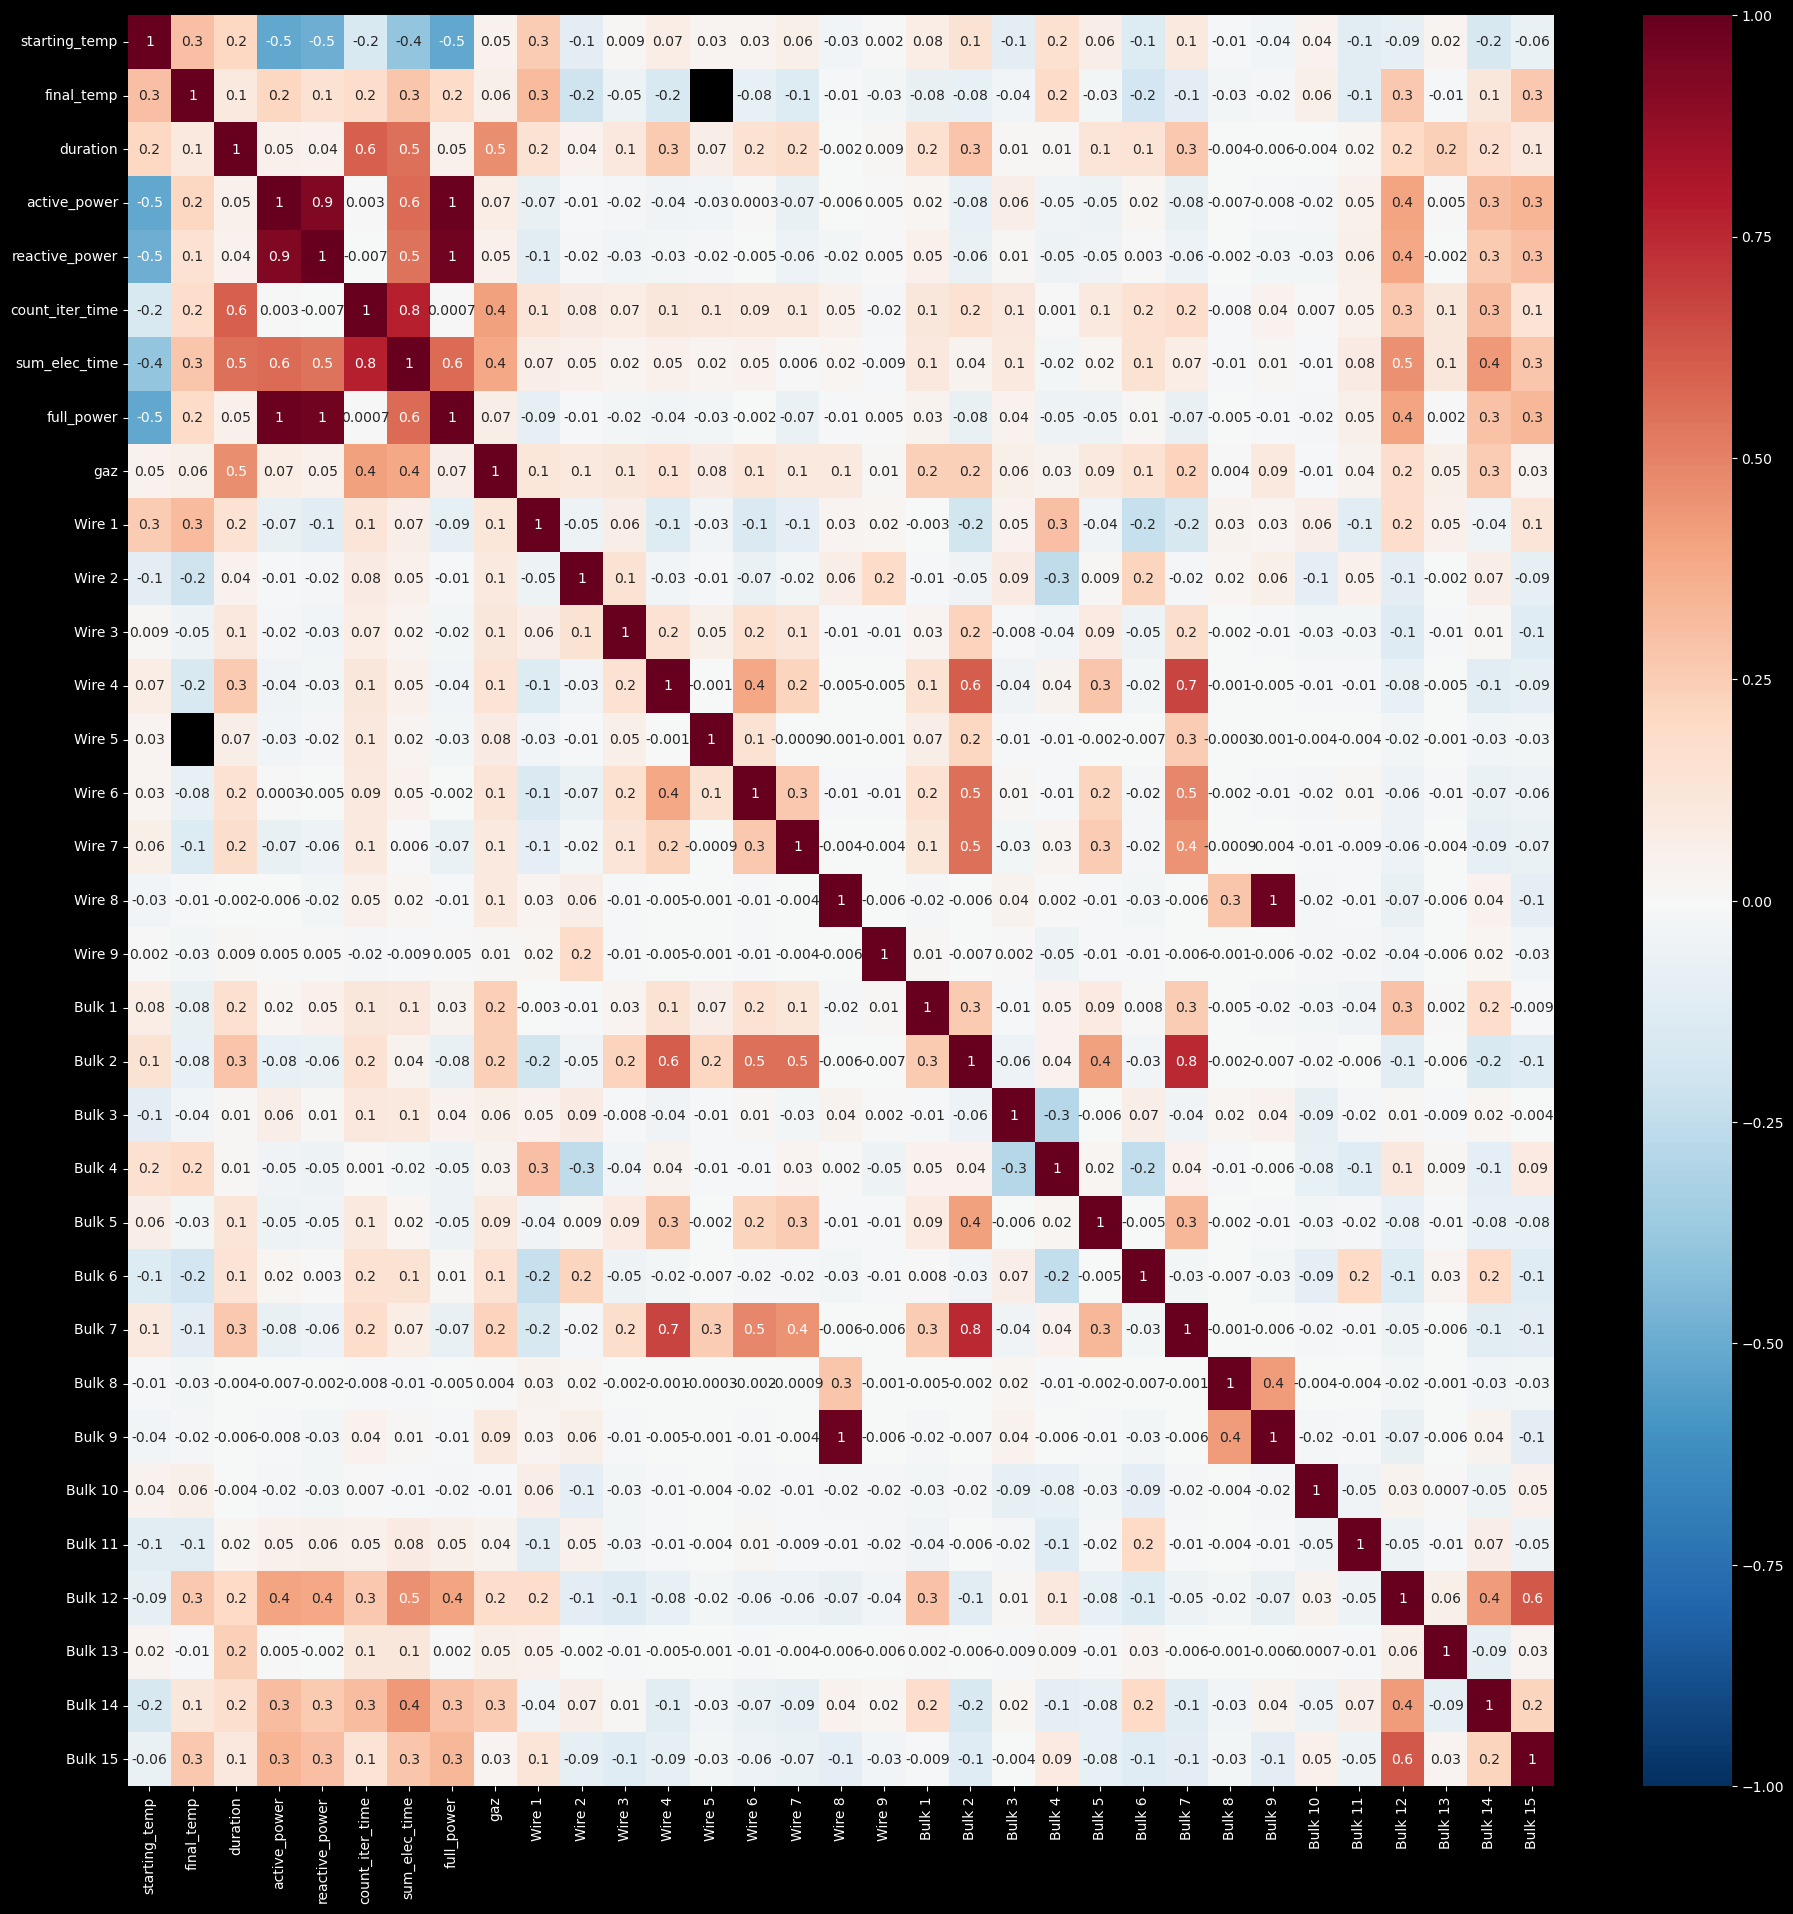

In [55]:
plt.figure(figsize=(23, 23))
sns.heatmap(df_full.corr(),
            annot=True,
            cmap='RdBu_r',
            fmt='.1g',
            vmin=-1,
            vmax=1)
plt.show()  # посмотрим на корреляцию 

**Видим связь у мощностей, что очевидно. Избавимся от активных и реактивных, т к полная мощность уже включаеют в себя ранее названные. Таже видим что Bulk 8 и Wire 5 не несут полезной информации, избавимся от них. Так как использовать будем "деревянные модели", нормализовать данные не будем, потому что наши модели устойчивы к корреляциям**

In [56]:
df_full = df_full.drop(columns=[
    'active_power', 'reactive_power', 'Bulk 8', 'Wire 5'
]) 

In [57]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 0 to 3016
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   starting_temp    3017 non-null   float64
 1   final_temp       2325 non-null   float64
 2   duration         3017 non-null   float64
 3   count_iter_time  3017 non-null   int64  
 4   sum_elec_time    3017 non-null   float64
 5   full_power       3017 non-null   float64
 6   gaz              3017 non-null   float64
 7   Wire 1           3017 non-null   float64
 8   Wire 2           3017 non-null   float64
 9   Wire 3           3017 non-null   float64
 10  Wire 4           3017 non-null   float64
 11  Wire 6           3017 non-null   float64
 12  Wire 7           3017 non-null   float64
 13  Wire 8           3017 non-null   float64
 14  Wire 9           3017 non-null   float64
 15  Bulk 1           3017 non-null   float64
 16  Bulk 2           3017 non-null   float64
 17  Bulk 3        

In [58]:
df_full = df_full.dropna() # удалим пустые ячейки

In [59]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   starting_temp    2325 non-null   float64
 1   final_temp       2325 non-null   float64
 2   duration         2325 non-null   float64
 3   count_iter_time  2325 non-null   int64  
 4   sum_elec_time    2325 non-null   float64
 5   full_power       2325 non-null   float64
 6   gaz              2325 non-null   float64
 7   Wire 1           2325 non-null   float64
 8   Wire 2           2325 non-null   float64
 9   Wire 3           2325 non-null   float64
 10  Wire 4           2325 non-null   float64
 11  Wire 6           2325 non-null   float64
 12  Wire 7           2325 non-null   float64
 13  Wire 8           2325 non-null   float64
 14  Wire 9           2325 non-null   float64
 15  Bulk 1           2325 non-null   float64
 16  Bulk 2           2325 non-null   float64
 17  Bulk 3        

После исследовательского анализа данных, нами была выполнена предобработка данных:
1. Получили средние активную и реактивную мощности, из которых была посчитана полная мощность, посчитали количество нагревов по партиям
2. Таблицы с данными об объеме сыпучих материалов и объеме проволочных материалов были заполненые нулями. Исходили из логики, что в тех данных, которые у нас есть, не добавлялись и те и другие, но они могут быть добавлены в следующий раз. Модель должна будет учитывать это.
3. Получили начальную и конечные температуры. Посчитали время (в секундах) замера температур. Посчитали количество итераций нагрева между начальной и конечной темперарурами
4. Подогнали данные под условия задача, а именно:
- диапазон температур начинается с 1500°
5. Удалили те данные, которые не подходили под логику "минимум 2 замера" и "разница между первым и последним замерами температуры не равны 0"
6. Собрали все в финальную таблицу
7. В итоге получилась таблица с 28 признаками и 1 целевым признаком, и 2325 строк. Строк не очень много, поэтому в обучении будем использовать кросс-валидацию

# Модели

In [60]:
train, test = train_test_split(
    df_full, test_size=0.25, random_state=270223
)  # разделим данные на тренировочный и обучающий датасеты в соотношении 75 к 25

In [61]:
target = ['final_temp']  # определяем целевой признак
features = df_full.drop(columns=['final_temp']).columns  # определяем признаки

In [65]:
models = [
    RandomForestRegressor(random_state=270223),
    CatBoostRegressor(random_seed=270223,
                      loss_function='RMSE',
                      eval_metric='MAE',
                      iterations=3000,
                      early_stopping_rounds=50,
                      verbose=False)
]  # создаем список с моделями

In [81]:
params = [{
    "n_estimators": randint(100, 500),
    "max_depth": randint(1, 50),
    "min_samples_split": randint(2, 50),
    "min_samples_leaf": randint(1, 50)
}, {
    'learning_rate': [0.02, 0.05],
    'depth': [3, 4, 5],
    'l2_leaf_reg': [2, 3, 4]
}]  # создаем словарь с параметрами для моделей

In [82]:
best_estimators = []  # создаем список, куда будем сохранять лучшие модели
best_scores = [
]  # создаем список, куда будем сохранять лучшие результаты метрик

for model, param in tqdm(
        zip(models, params)
):  # пишем цикл, который берет модель и параметры, а затем подбирает лучший набор параметров
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param,
                                       n_iter=10,
                                       cv=5,
                                       random_state=270223,
                                       scoring='neg_mean_absolute_error')

    random_search.fit(train[features], np.ravel(train[target]))

    best_estimators.append(random_search.best_estimator_)
    best_scores.append(random_search.best_score_)

print(f'Лучший результат МАЕ RandomForestRegressor {round(-best_scores[0],4)}')
print(f'Лучший результат МАЕ CatBoostRegressor {round(-best_scores[1], 4)}')

2it [04:02, 121.29s/it]

Лучший результат МАЕ RandomForestRegressor 5.8897
Лучший результат МАЕ CatBoostRegressor 5.5313


In [70]:
y_pred = best_estimators[1].predict(test[features])

In [71]:
print(
    f'Финальное МАЕ на тестовой выборке {round(mean_absolute_error(test[target], y_pred), 4)}'
)

Финальное МАЕ на тестовой выборке 5.9788


## Сравним с константной

In [72]:
const = DummyRegressor(strategy="mean").fit(train[features], np.ravel(train[target]))

In [73]:
const_pred = const.predict(test[features])

In [74]:
print(
    f'МАЕ на тестовой выборке константой модели {round(mean_absolute_error(test[target], const_pred), 4)}'
)

МАЕ на тестовой выборке константой модели 8.5558


## Посмотрим на модель с помощью shap

In [75]:
explainer = shap.TreeExplainer(best_estimators[1])  # создаем explainer

In [76]:
shap_values = explainer.shap_values(test[features]) # создаем значения

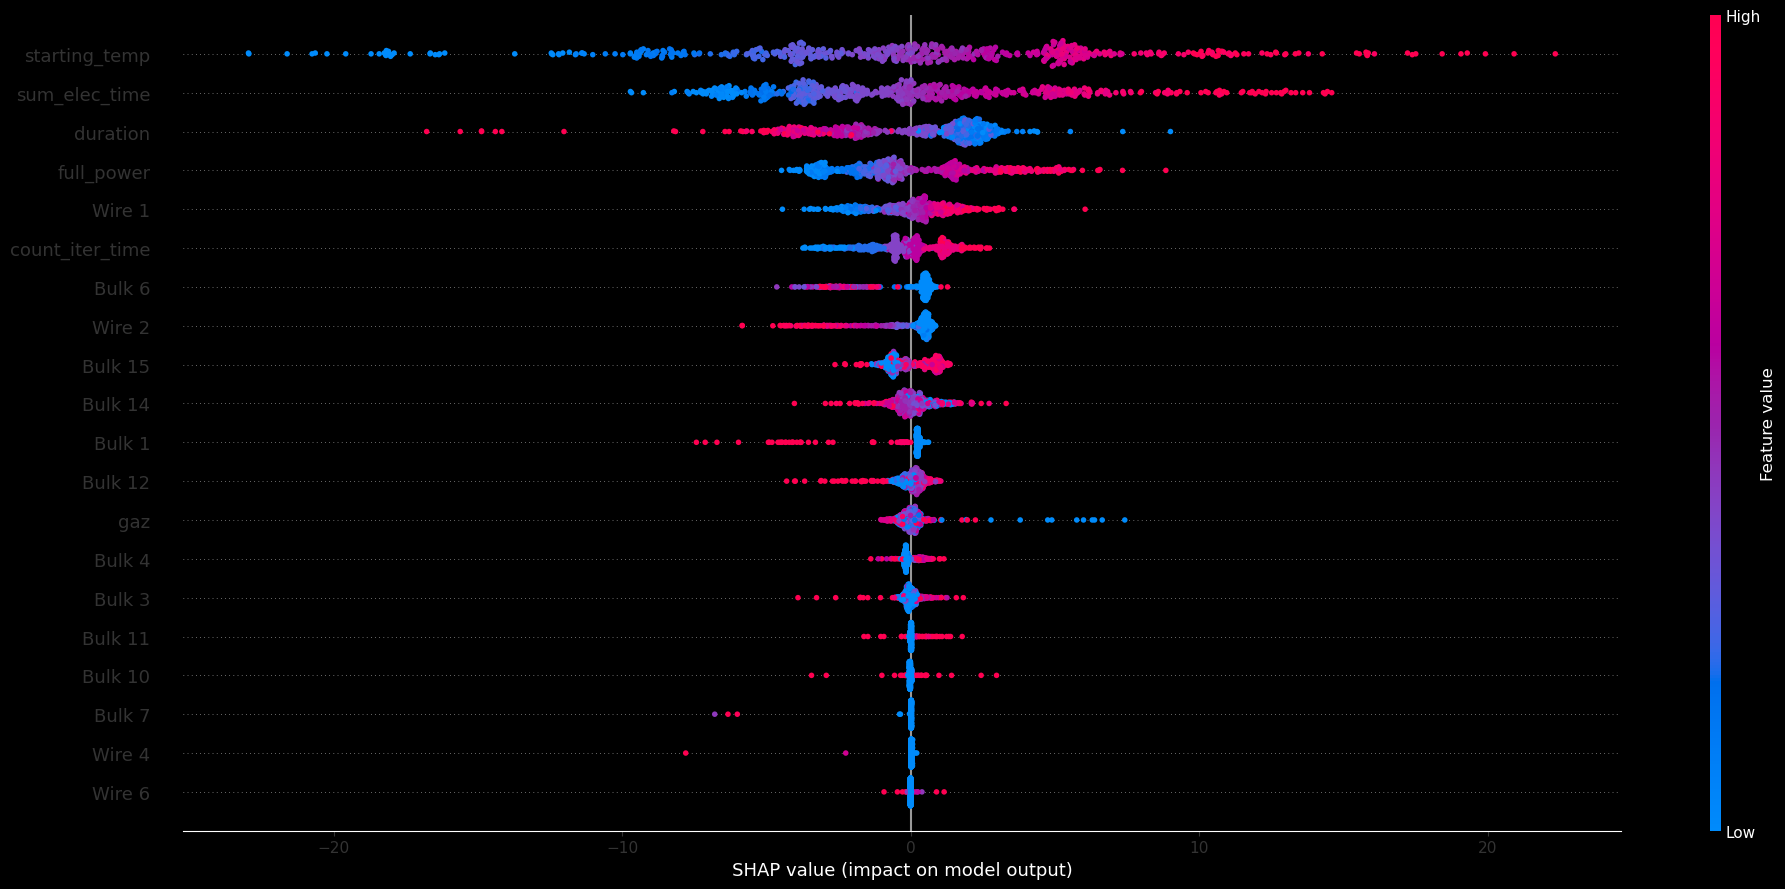

In [77]:
shap.summary_plot(shap_values, test[features], plot_size=(20, 9)) # строим plot

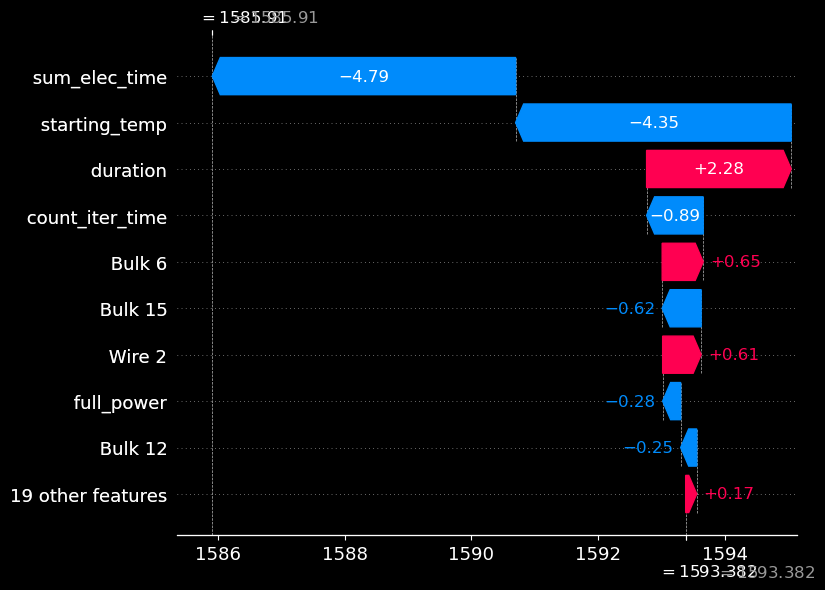

In [78]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[500],
    features=features,
    feature_names=test[features].columns,
    show=True)  # визуализируем значимость параметров одного примера

Исходя из графика важность признаков для модели градиентного бустинга следующая:

* на первом месте **начальная температура**
* сумарный **сумарный нагрев по партии**
* далее идет **время между первым и последним замерами**
* затем **полная мощность**
* далее следуют оставшиеся признаки примерно в равном соотношении


# Отчет

Необходимо было построить модель, которая будет прогнозировать финальную температуру стали по историческим данным. Имелись 7 датафреймов с различной информацией о технологическом процессе.


**Исследовательский анализ** - загрузка всех имеющихся данных, изучение графиков/статистик для понимания того, что нужно выполнить. Было обнаружено, что не все сыпучие и проволочные материалы используются в технологическом процессе, много выбросов и пропусков, таблицы имеют разный размер. В каждой таблице графа 'key' отвечает за одну партию, если значений несколько, то это говорит о том, что производилось несколько итераций лигирования для одной партии.

**Предобработка данных:**

* Обработка выбросов;
* Создание дополнительных признаков для моделей: средние полные мощности по партиям, количество нагревов и время суммарного нагрева по партиям;
* Получение начальной температуры и финальной температуры (целевая переменная), а также времени между первым и финальными замерами (сек.);
* Использование только необходимых данных из таблицы с датами подачи материалов;
* Заполнение пропусков в сыпучих и проволочных материалах нулями;
* Сбор всех данных в одну таблицу по столбцу 'key';
* Установление ограничений на минимальную температуру (1500°) и минимальное количество замеров (2 замера на каждую партию);
* Построение тепловой карты корреляций, которая помогла выявить сильные корреляции между отдельными признаками, а также удалить ненужные столбцы.
* Моделирование - обучение с помощью кросс-валидации древовидных моделей: RandomForestRegressor и CatBoostRegressor. В качестве метрики использовалась MAE (mean absolute error). По результатам кросс-валидации было выявлено, что CatBoostRegressor показывает себя лучше, MAE на обучающей выборке равно 0.53. Модель была проверена на тестовых данных и MAE получилось 0.59, что удовлетворяет условие MAE < 6.8.


**Конечные выводы и результаты анализа работы модели:**

* Данные были обработаны.
* Модель была разработана.
* Наиболее значимыми переменными для прогнозирования являются начальная температура, суммарное время нагрева, разница между первым и последним замерами, полная мощность, добавка Wire 1, количество итераций нагрева и определенные Bulk-материалы.
* Интересно, что модель считает газ почти незначительным признаком.
* Финальная метрика удовлетворяет условию.
* Были проведены различные манипуляции с обучающими признаками и их количеством. Наилучшая метрика достигнута с помощью представленного набора признаков.
* Однако, хорошая метрика достигается даже если оставить только некоторые основные признаки, такие как начальная температура, конечная температура, продолжительность, активная мощность, реактивная мощность, количество итераций нагрева, суммарное время электрического нагрева, газ и добавка Wire 1. Но, это может привести к потере множества информации в будущем.

